In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [69]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [70]:
class DNN_5(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_5, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        
        x = torch.relu(self.bn2(self.layer2(x)))
        

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [71]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [72]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデル定義
    model = DNN_5(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 300
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [73]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:28,521] A new study created in memory with name: no-name-349ffa7f-089b-400b-b743-17a2ff6fc439
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:54,992] Trial 0 finished with value: 0.16188890055161048 and parameters: {'dropout1': 0.1, 'dropout2': 0.45, 'learning_rate': 4.151415610290663e-05, 'weight_decay': 2.6883577542795713e-05}. Best is trial 0 with value: 0.16188890055161

Early stopping at epoch 194
Final MCC: 0.1619


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:58,506] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 0.09161071424473073, 'weight_decay': 0.0004288277732923043}. Best is trial 0 with value: 0.16188890055161048.


Early stopping at epoch 25
Final MCC: 0.0000


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:01,323] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.35000000000000003, 'learning_rate': 0.04202439304754557, 'weight_decay': 0.000885366183084464}. Best is trial 0 with value: 0.16188890055161048.


Early stopping at epoch 19
Final MCC: 0.0000


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:42,106] Trial 3 finished with value: 0.310300768874618 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 5.1335327873592435e-05, 'weight_decay': 9.243414043418081e-05}. Best is trial 3 with value: 0.310300768874618.


Final MCC: 0.3103


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:46,376] Trial 4 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.25, 'learning_rate': 0.025646742280476007, 'weight_decay': 0.0006932246863822582}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:48,897] Trial 5 finished with value: 0.082439811313417 and parameters: {'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.009518628823539826, 'weight_decay': 0.0001990906749294706}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 17
Final MCC: 0.0824


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:52,318] Trial 6 pruned. 
[I 2024-12-12 21:02:55,760] Trial 7 pruned. 
[I 2024-12-12 21:02:58,122] Trial 8 finished with value: 0.0737043474095502 and parameters: {'dropout1': 0.05, 'dropout2': 0.25, 'learning_rate': 0.003989994114850586, 'weight_decay': 0.00014617188310652465}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 17
Final MCC: 0.0737


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:20,646] Trial 9 finished with value: 0.1989245664287416 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 9.11144297222241e-05, 'weight_decay': 0.022395923229308567}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 169
Final MCC: 0.1989


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:23,157] Trial 10 pruned. 
[I 2024-12-12 21:03:25,830] Trial 11 pruned. 
[I 2024-12-12 21:03:52,048] Trial 12 finished with value: 0.12992764989037156 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 8.398618463602441e-05, 'weight_decay': 0.005163181750541515}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 195
Final MCC: 0.1299


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:04:10,900] Trial 13 finished with value: 0.033821702544744994 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 1.0670662119010044e-05, 'weight_decay': 0.06343428064154363}. Best is trial 3 with value: 0.310300768874618.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

Early stopping at epoch 141
Final MCC: 0.0338


[I 2024-12-12 21:04:14,480] Trial 15 pruned. 
[I 2024-12-12 21:04:32,578] Trial 16 finished with value: 0.18338951892834085 and parameters: {'dropout1': 0.5, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001661395141851536, 'weight_decay': 0.018013620692417277}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 133
Final MCC: 0.1834


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:04:34,118] Trial 17 finished with value: 0.037676974181154996 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.0, 'learning_rate': 3.168741537847925e-05, 'weight_decay': 4.022982708517459e-05}. Best is trial 3 with value: 0.310300768874618.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated i

Early stopping at epoch 10
Final MCC: 0.0377


[I 2024-12-12 21:04:34,457] Trial 19 pruned. 
[I 2024-12-12 21:05:07,992] Trial 20 finished with value: 0.3089056477310863 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 2.0162904664755754e-05, 'weight_decay': 0.03138470841048863}. Best is trial 3 with value: 0.310300768874618.


Early stopping at epoch 262
Final MCC: 0.3089


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:05:47,300] Trial 21 finished with value: 0.25664779636310886 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 2.4501016891137328e-05, 'weight_decay': 0.017465584980873056}. Best is trial 3 with value: 0.310300768874618.


Final MCC: 0.2566


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:06:25,168] Trial 22 finished with value: 0.33796521256442164 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 2.324069448291899e-05, 'weight_decay': 0.03728973969379139}. Best is trial 22 with value: 0.33796521256442164.


Final MCC: 0.3380


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:06:25,477] Trial 23 pruned. 
[I 2024-12-12 21:06:25,657] Trial 24 pruned. 
[I 2024-12-12 21:06:46,832] Trial 25 finished with value: 0.1466203639684671 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 1.242426463836261e-05, 'weight_decay': 0.006435525566815623}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 161
Final MCC: 0.1466


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:06:59,851] Trial 26 finished with value: 0.14928711240257503 and parameters: {'dropout1': 0.25, 'dropout2': 0.4, 'learning_rate': 0.00034487972224019693, 'weight_decay': 0.0019404580845477136}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 95
Final MCC: 0.1493


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:07:01,334] Trial 27 finished with value: 0.0 and parameters: {'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 6.579103082212222e-05, 'weight_decay': 0.0003110297633129475}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:07:23,248] Trial 28 finished with value: 0.2359356346263649 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 2.1342420092754176e-05, 'weight_decay': 0.039128855011118624}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated 

Early stopping at epoch 173
Final MCC: 0.2359


[I 2024-12-12 21:07:23,565] Trial 30 pruned. 
[I 2024-12-12 21:07:59,894] Trial 31 finished with value: 0.22594529792389728 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 2.4715460524701547e-05, 'weight_decay': 0.034930945156968374}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 265
Final MCC: 0.2259


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:08:26,901] Trial 32 finished with value: 0.16757096431073037 and parameters: {'dropout1': 0.4, 'dropout2': 0.45, 'learning_rate': 3.935914099228864e-05, 'weight_decay': 0.08885843306018558}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

Early stopping at epoch 197
Final MCC: 0.1676


[I 2024-12-12 21:08:28,634] Trial 34 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.4, 'learning_rate': 1.0925737838573355e-05, 'weight_decay': 0.004040860975730926}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:08:28,799] Trial 35 pruned. 


Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-12 21:08:28,961] Trial 36 pruned. 
[I 2024-12-12 21:09:10,629] Trial 37 finished with value: 0.23307361127050974 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'learning_rate': 4.566526181016741e-05, 'weight_decay': 0.009116631231038607}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:09:10,752] Trial 38 pruned. 


Final MCC: 0.2331


[I 2024-12-12 21:09:10,878] Trial 39 pruned. 
[I 2024-12-12 21:09:11,051] Trial 40 pruned. 
[I 2024-12-12 21:09:12,670] Trial 41 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 2.4776828475998926e-05, 'weight_decay': 0.03981925855632664}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:09:14,076] Trial 42 finished with value: 0.007049073768502414 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 1.6678354854717783e-05, 'weight_decay': 0.029583579695538556}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 10
Final MCC: 0.0070


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:09:34,924] Trial 43 finished with value: 0.2374541732414539 and parameters: {'dropout1': 0.4, 'dropout2': 0.45, 'learning_rate': 6.868622122411551e-05, 'weight_decay': 0.09539421759521308}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Early stopping at epoch 154
Final MCC: 0.2375


[I 2024-12-12 21:09:35,217] Trial 45 pruned. 
[I 2024-12-12 21:09:35,391] Trial 46 pruned. 
[I 2024-12-12 21:09:35,552] Trial 47 pruned. 
[I 2024-12-12 21:09:35,699] Trial 48 pruned. 
[I 2024-12-12 21:10:11,448] Trial 49 finished with value: 0.2942062325701188 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'learning_rate': 6.000721393665909e-05, 'weight_decay': 0.0011525530006237458}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 270
Final MCC: 0.2942


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:10:11,755] Trial 50 pruned. 
[I 2024-12-12 21:10:11,927] Trial 51 pruned. 
[I 2024-12-12 21:10:12,092] Trial 52 pruned. 
[I 2024-12-12 21:10:12,256] Trial 53 pruned. 
[I 2024-12-12 21:10:31,595] Trial 54 finished with value: 0.27357400523970277 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 3.1473080757996544e-05, 'weight_decay'

Early stopping at epoch 150
Final MCC: 0.2736


[I 2024-12-12 21:11:12,994] Trial 56 finished with value: 0.2341589441664689 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'learning_rate': 1.3898590936006262e-05, 'weight_decay': 5.212168617880603e-05}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:11:13,144] Trial 57 pruned. 


Final MCC: 0.2342


[I 2024-12-12 21:11:14,638] Trial 58 finished with value: 0.13213887210171935 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 1.4825529563900404e-05, 'weight_decay': 3.1477674380960035e-05}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:11:14,814] Trial 59 pruned. 


Early stopping at epoch 10
Final MCC: 0.1321


[I 2024-12-12 21:11:14,990] Trial 60 pruned. 
[I 2024-12-12 21:11:15,157] Trial 61 pruned. 
[I 2024-12-12 21:11:15,348] Trial 62 pruned. 
[I 2024-12-12 21:11:15,499] Trial 63 pruned. 
[I 2024-12-12 21:11:15,674] Trial 64 pruned. 
[I 2024-12-12 21:11:15,806] Trial 65 pruned. 
[I 2024-12-12 21:11:15,977] Trial 66 pruned. 
[I 2024-12-12 21:11:39,708] Trial 67 finished with value: 0.2057735570350114 and parameters: {'dropout1': 0.05, 'dropout2': 0.5, 'learning_rate': 8.297587521743262e-05, 'weight_decay': 0.0015039437212179929}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.

Early stopping at epoch 167
Final MCC: 0.2058


[I 2024-12-12 21:11:46,851] Trial 69 finished with value: 0.12154964410333503 and parameters: {'dropout1': 0.5, 'dropout2': 0.45, 'learning_rate': 0.0005490058486277606, 'weight_decay': 0.03166261788097706}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:11:47,015] Trial 70 pruned. 


Early stopping at epoch 54
Final MCC: 0.1215


[I 2024-12-12 21:11:47,137] Trial 71 pruned. 
[I 2024-12-12 21:11:47,307] Trial 72 pruned. 
[I 2024-12-12 21:11:47,467] Trial 73 pruned. 
[I 2024-12-12 21:11:47,624] Trial 74 pruned. 
[I 2024-12-12 21:12:19,218] Trial 75 finished with value: 0.29685993184495857 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'learning_rate': 2.0509536984110982e-05, 'weight_decay': 0.050408332402203916}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Early stopping at epoch 243
Final MCC: 0.2969


[I 2024-12-12 21:12:20,976] Trial 77 finished with value: 0.0 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 2.7915190361377143e-05, 'weight_decay': 0.09686315389854722}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:12:21,161] Trial 78 pruned. 


Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-12 21:12:21,320] Trial 79 pruned. 
[I 2024-12-12 21:12:23,029] Trial 80 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'learning_rate': 5.5348006159327916e-05, 'weight_decay': 0.0528051432240667}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:12:23,164] Trial 81 pruned. 


Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-12 21:12:47,449] Trial 82 finished with value: 0.33062280550248807 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 4.160665638143223e-05, 'weight_decay': 0.028944082987516478}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:12:47,591] Trial 83 pruned. 


Early stopping at epoch 179
Final MCC: 0.3306


[I 2024-12-12 21:12:47,759] Trial 84 pruned. 
[I 2024-12-12 21:12:47,903] Trial 85 pruned. 
[I 2024-12-12 21:12:49,381] Trial 86 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 3.16143210663151e-05, 'weight_decay': 0.0061556418499412405}. Best is trial 22 with value: 0.33796521256442164.
/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:12:49,535] Trial 

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-12 21:12:49,730] Trial 88 pruned. 
[I 2024-12-12 21:12:49,909] Trial 89 pruned. 
[I 2024-12-12 21:12:50,075] Trial 90 pruned. 
[I 2024-12-12 21:12:50,232] Trial 91 pruned. 
[I 2024-12-12 21:12:50,398] Trial 92 pruned. 
[I 2024-12-12 21:12:50,559] Trial 93 pruned. 
[I 2024-12-12 21:12:50,706] Trial 94 pruned. 
[I 2024-12-12 21:12:50,834] Trial 95 pruned. 
[I 2024-12-12 21:12:50,969] Trial 96 pruned. 
[I 2024-12-12 21:12:51,091] Trial 97 pruned. 
[I 2024-12-12 21:12:52,603] Trial 98 finished with value: 0.04 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 1.0037086410427639e-05, 'weight_decay': 0.027345233091030218}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 10
Final MCC: 0.0400


/tmp/ipykernel_1382552/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_1382552/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:13:15,165] Trial 99 finished with value: 0.3095442035396405 and parameters: {'dropout1': 0.45, 'dropout2': 0.5, 'learning_rate': 3.41206202547457e-05, 'weight_decay': 0.00012214109868813783}. Best is trial 22 with value: 0.33796521256442164.


Early stopping at epoch 166
Final MCC: 0.3095
Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 2.324069448291899e-05, 'weight_decay': 0.03728973969379139}
Best Validation F1:  0.33796521256442164


In [74]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_5_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/125], Loss: 0.7209
Epoch [1/125], Train Loss: 0.7209, Val Loss: 0.7096
Epoch [2/125], Loss: 0.7204
Epoch [2/125], Train Loss: 0.7204, Val Loss: 0.7051
Epoch [3/125], Loss: 0.7145
Epoch [3/125], Train Loss: 0.7145, Val Loss: 0.7037
Epoch [4/125], Loss: 0.7157
Epoch [4/125], Train Loss: 0.7157, Val Loss: 0.7027
Epoch [5/125], Loss: 0.7206
Epoch [5/125], Train Loss: 0.7206, Val Loss: 0.7016
Epoch [6/125], Loss: 0.7168
Epoch [6/125], Train Loss: 0.7168, Val Loss: 0.7026
Epoch [7/125], Loss: 0.7077
Epoch [7/125], Train Loss: 0.7077, Val Loss: 0.7005
Epoch [8/125], Loss: 0.7134
Epoch [8/125], Train Loss: 0.7134, Val Loss: 0.7012
Epoch [9/125], Loss: 0.7164
Epoch [9/125], Train Loss: 0.7164, Val Loss: 0.6997
Epoch [10/125], Loss: 0.7137
Epoch [10/125], Train Loss: 0.7137, Val Loss: 0.6996
Epoch [11/125], Loss: 0.7074
Epoch [11/125], Train Loss: 0.7074, Val Loss: 0.6981
Epoch [12/125], Loss: 0.7100
Epoch [12/125], Train Loss: 0.7100, Val Loss: 0.6968
Epoch [13/125], Loss: 0.7130
Epoch

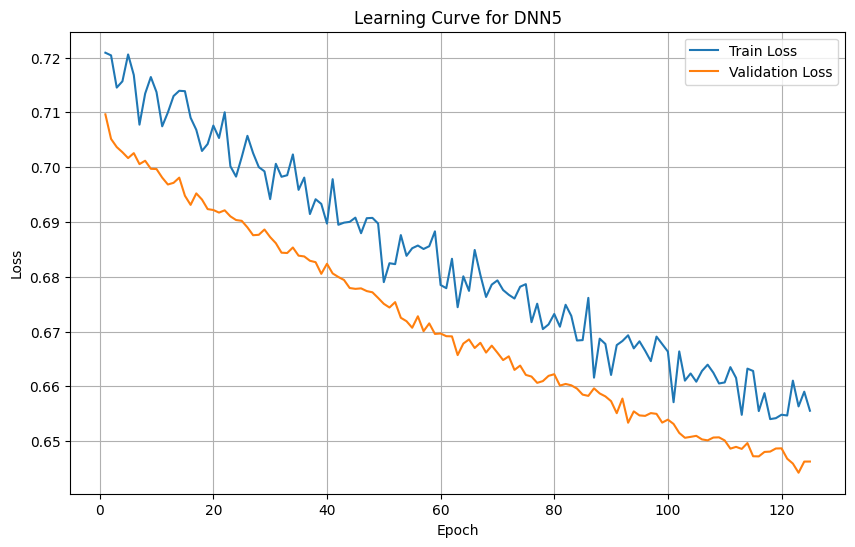

In [123]:
best_params=study.best_params
model = DNN_5(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              ).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=125
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN5')
plt.legend()
plt.grid()
plt.show()

Accuracy: 55.92%
Precision: 0.4639
Recall: 0.9086
F1 Score: 0.6142
Matthews Correlation Coefficient: 0.2813
Specificity: 0.3395


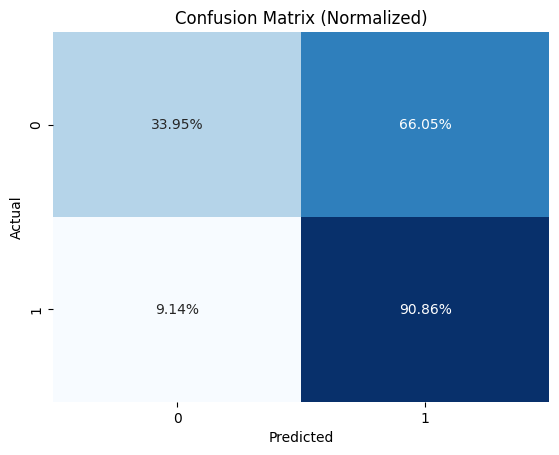

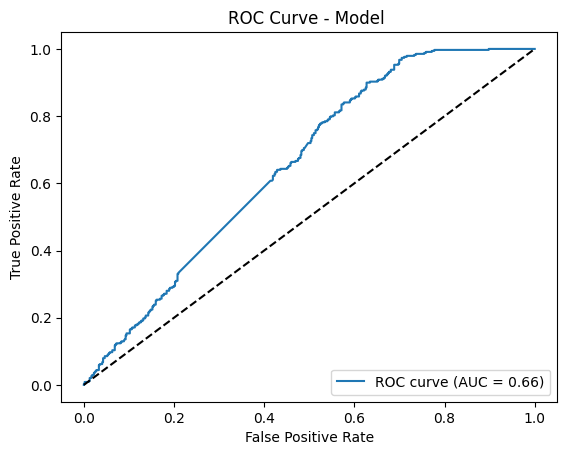

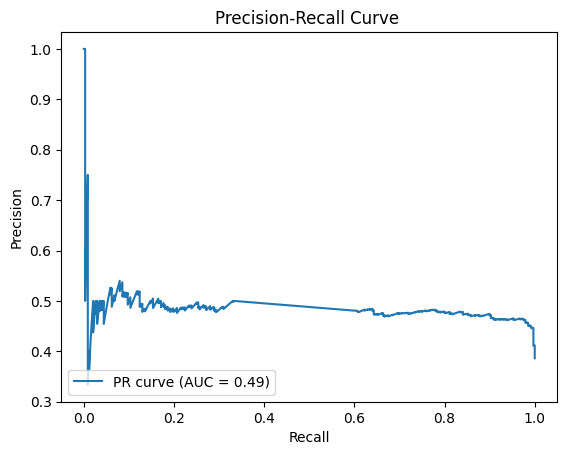

In [124]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [77]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_5.pth')




In [78]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
            Linear-3                   [-1, 16]             528
       BatchNorm1d-4                   [-1, 16]              32
            Linear-5                    [-1, 8]             136
       BatchNorm1d-6                    [-1, 8]              16
           Dropout-7                    [-1, 8]               0
            Linear-8                    [-1, 4]              36
       BatchNorm1d-9                    [-1, 4]               8
          Dropout-10                    [-1, 4]               0
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back